In [2]:
import pandas as pd
import json
import tweepy as tw
import configparser
import numpy as np
import re

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#Conexão com o MongoDb
from pymongo import MongoClient


## CONECTANDO AO config.ini

In [3]:
config = configparser.ConfigParser()
config.read("config.ini")

['config.ini']

## CONECTANDO AO BD ELEICOES2022

In [4]:
mongo = config["mongodb"]["mongo"]

In [5]:
#conectando ao mongoDB
client_db = MongoClient(mongo)

In [6]:
#Conectando ao banco de dados eleicoes2022
db = client_db.get_database("eleicoes2022_db")

In [8]:
#CONECTANDO AO COLLECTION NAME TWEETS
collection_tweets = db.tweets_

## CONECTANDO AO TWITTER

In [11]:
api_key = config["twitter"]["api_key"]
api_key_secret = config["twitter"]["api_key_secret"]
access_token = config["twitter"]["access_token"]
access_token_secret = config["twitter"]["access_token_secret"]

In [12]:
#Authentication
auth = tw.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth)

In [ ]:
# tw.Cursor(api.search_tweets)

In [ ]:
# #teste de conexão - home-timeline
# public_tweets = api.home_timeline()
# for tweet in public_tweets:
#     print(tweet.text)

## PESQUISANDO #ELEICOES2022

In [19]:
# search_words = "#Eleições2022"
query_words = "#Eleições2022 #Eleicoes2022" + "-filter:retweets" 

In [20]:
#Escolhendo tema especifico
tweets = tw.Cursor(api.search_tweets,
                    q = query_words).items(1000)

In [ ]:
# for tweet in tweets:
#     print(tweet.created_at)
#     print(tweet.text)

In [ ]:
# tweets_dict = {}
# tweets_dict = tweets_dict.fromkeys(tweet._json.keys())
# type(tweets_dict)

In [21]:
lista_tweets = []
for tweet in tweets:
    data = tweet._json
    tweets_dict = {key : value for key, value in data.items()}
    lista_tweets.append(tweets_dict)

In [22]:
#CRIANDO DF_TWEETS
df_tweets = pd.DataFrame.from_dict(lista_tweets)

In [23]:
df_tweets.shape

(838, 29)

In [24]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   created_at                 838 non-null    object 
 1   id                         838 non-null    int64  
 2   id_str                     838 non-null    object 
 3   text                       838 non-null    object 
 4   truncated                  838 non-null    bool   
 5   entities                   838 non-null    object 
 6   metadata                   838 non-null    object 
 7   source                     838 non-null    object 
 8   in_reply_to_status_id      100 non-null    float64
 9   in_reply_to_status_id_str  100 non-null    object 
 10  in_reply_to_user_id        109 non-null    float64
 11  in_reply_to_user_id_str    109 non-null    object 
 12  in_reply_to_screen_name    109 non-null    object 
 13  user                       838 non-null    object 

In [25]:
df_tweets.columns

Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'is_quote_status',
       'retweet_count', 'favorite_count', 'favorited', 'retweeted',
       'possibly_sensitive', 'lang', 'extended_entities', 'quoted_status_id',
       'quoted_status_id_str', 'quoted_status'],
      dtype='object')

In [26]:
#SELECIONANDO COLUNAS MAIS RELEVANTES
df_tweets_short = df_tweets[['created_at','text', 'truncated',
       'metadata', 'source', "user", 'retweet_count', 'retweeted', 'lang']]

*USANDO REGEX*

In [27]:
#EXCLUINDO LINKS NA FEATURE TEXT
for idx, texto in enumerate(df_tweets_short["text"]):
    padrao = re.compile('https:.+')
    if padrao.findall(texto):
        https = padrao.findall(texto)
        df_tweets_short["text"][idx] = df_tweets_short["text"][idx].replace(https[0], "")

C:\Users\Usuário\AppData\Local\Temp\ipykernel_3476\1636851568.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_short["text"][idx] = df_tweets_short["text"][idx].replace(https[0], "")


In [28]:
pd.options.display.max_colwidth = 130
df_tweets_short["text"]

0       Teto de gastos ‘não é uma conspiração para desmontar a área social’. Leia a carta de Arminio Fraga, Edmar Bacha e P… 
1                                     E ainda tem gente dizendo que nada está acontecendo… #bolsonaro #Eleicoes2022 #Noticia 
2                                                                             #LulaPresidente2022 #Eleicoes2022 #informacion 
3                                                                                          Baba ovo do cacete! #Eleicoes2022 
4                     🗣No Egito Lula conversa com o mundo sobre Amazônia. No Brasil militares reencenam golpismo mumificado… 
                                                                ...                                                          
833       Esse é o maior tapa na cara que a sociedade pode levar!\n#barroso #lula #novayork #Eleicoes2022 #bolsonaro #brasil 
834             November 14th 2022\n2022年１１月１４日\nSalvador Bahia Brasil\n#ルラ　#ボウソナロ　#ブラジル大統領選　#Brazil \n#Brasil #Eleico

In [29]:
#CRIANDO FEATURE USUARIO
df_tweets_short["usuario"] = np.nan
for idx in df_tweets_short.index:
    df_tweets_short["usuario"][idx] = df_tweets_short["user"][idx]["screen_name"]

C:\Users\Usuário\AppData\Local\Temp\ipykernel_3476\3867158451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_short["usuario"] = np.nan
C:\Users\Usuário\AppData\Local\Temp\ipykernel_3476\3867158451.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_short["usuario"][idx] = df_tweets_short["user"][idx]["screen_name"]


In [30]:
#EXCLUINDO CARACTERES \n (caracter de quebra de linha)
for idx, texto in enumerate(df_tweets_short["text"]):
    df_tweets_short["text"][idx] =  texto.replace("\n", "")

C:\Users\Usuário\AppData\Local\Temp\ipykernel_3476\3296765182.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_short["text"][idx] =  texto.replace("\n", "")


In [31]:
df_tweets_short = df_tweets_short[['created_at','text', 'truncated',
       'metadata', 'source', 'retweet_count', 'retweeted', 'lang']]

## TRANSFORMAR JSON E SALVANDO NO BD

In [32]:
df_tweets_short.to_json("data/json_tweets.json", orient = "index")

In [33]:
with open('data/json_tweets.json') as f:
  json_tweets = json.load(f)

  collection_tweets.insert_many(json_tweets.values())

## IMPORTANDO DADOS DO BD

In [181]:
tweets = pd.DataFrame(list(collection_tweets.find()))

In [182]:
tweets.head()

,_id,created_at,text,truncated,metadata,source,retweet_count,retweeted,lang
0,637786f0f88d752f97e1d28c,Thu Nov 17 14:42:43 +0000 2022,"In Brazil And U.S., Elections As Stress Tests ...",True,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",0,False,en
1,637786f0f88d752f97e1d28d,Thu Nov 17 14:42:42 +0000 2022,Continuamos na luta! #brazilwasstollen #Eleico...,False,"{'iso_language_code': 'pt', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",0,False,pt
2,637786f0f88d752f97e1d28e,Thu Nov 17 14:36:46 +0000 2022,Veja a lista de 43 pessoas físicas e jurídicas...,True,"{'iso_language_code': 'pt', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",0,False,pt
3,637786f0f88d752f97e1d28f,Thu Nov 17 14:36:27 +0000 2022,É a política no Brasil tá como? #Politica #Bra...,False,"{'iso_language_code': 'pt', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",0,False,pt
4,637786f0f88d752f97e1d290,Thu Nov 17 14:25:43 +0000 2022,@Seondetails #PERDEUMANÉ#LulaJá #LulaPresident...,True,"{'iso_language_code': 'und', 'result_type': 'r...","<a href=""https://mobile.twitter.com"" rel=""nofo...",0,False,und


## TRATAMENTO DOS DADOS

In [183]:
tweets["created_at"] = pd.to_datetime(tweets["created_at"])

*CRIANDO FEATURES ANO, MES, DIA DA SEMANA*

In [184]:
tweets['year'] = tweets['created_at'].dt.year
tweets['month'] = tweets['created_at'].dt.month
tweets['day'] = tweets['created_at'].dt.day
tweets["weekday"] = tweets['created_at'].dt.weekday
tweets["dayname"] = tweets['created_at'].dt.day_name()

In [185]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   _id            804 non-null    object             
 1   created_at     804 non-null    datetime64[ns, UTC]
 2   text           804 non-null    object             
 3   truncated      804 non-null    bool               
 4   metadata       804 non-null    object             
 5   source         804 non-null    object             
 6   retweet_count  804 non-null    int64              
 7   retweeted      804 non-null    bool               
 8   lang           804 non-null    object             
 9   year           804 non-null    int64              
 10  month          804 non-null    int64              
 11  day            804 non-null    int64              
 12  weekday        804 non-null    int64              
 13  dayname        804 non-null    object             

In [180]:
tweets.head()

,created_at,text,retweet_count,year,month,day,weekday,dayname,how,hashtag,@,#
0,2022-11-17 14:42:43+00:00,"In Brazil And U.S., Elections As Stress Tests ...",0,2022,11,17,3,Thursday,Twitter Web App,NaN,NaN,"[#politics, #brazil, #UnitedStates, #democracy..."
1,2022-11-17 14:42:42+00:00,Continuamos na luta! #brazilwasstollen #Eleico...,0,2022,11,17,3,Thursday,Twitter for Android,NaN,NaN,"[#brazilwasstollen, #Eleicoes2022]"
2,2022-11-17 14:36:46+00:00,Veja a lista de 43 pessoas físicas e jurídicas...,0,2022,11,17,3,Thursday,Twitter for Android,NaN,NaN,NaN
3,2022-11-17 14:36:27+00:00,É a política no Brasil tá como? #Politica #Bra...,0,2022,11,17,3,Thursday,Twitter for iPhone,NaN,[@iRodolffo],"[#Politica, #Brasil, #Eleicoes2022]"
4,2022-11-17 14:25:43+00:00,@Seondetails #PERDEUMANÉ#LulaJá #LulaPresident...,0,2022,11,17,3,Thursday,Twitter Web App,NaN,[@Seondetails],"[#PERDEUMANÉ, #LulaJá, #LulaPresidente, #Lula2..."


*CRIANDO FEATURE COMO O TWEET FOI POSTADO*

In [186]:
caracteres = "<>"
tweets["how"] = np.nan
for idx, dado in enumerate(tweets["source"]):
    padrao = re.compile('>.+<')
    texto = padrao.findall(dado)[0]
    for caracter in caracteres:
        texto = texto.replace(caracter, "")
    
    tweets["how"][idx] = texto

C:\Users\Usuário\AppData\Local\Temp\ipykernel_7160\551239072.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets["how"][idx] = texto


In [187]:
tweets["how"].value_counts()

Twitter for Android                340
Twitter for iPhone                 184
Twitter Web App                    182
IFTTT                               49
Instagram                           14
Hootsuite Inc.                       8
mLabs - Gestão de Redes Sociais      6
TweetDeck                            4
Etus Brasil                          3
Zapier.com                           3
chainalpha                           2
areavip                              2
Blog2Social APP                      1
Prodigious Test                      1
Twitter Media Studio                 1
Paper.li                             1
Portal Alta Definição                1
WordPress.com                        1
Market for Ideas                     1
Name: how, dtype: int64

## PEGANDO # E @ 

In [188]:
tweets["#"] = np.nan
tweets["@"] = np.nan

In [190]:
for idx, tweet in enumerate(tweets["text"]):
    hashtag = re.findall(r'#\w+', tweet)
    arroba = re.findall(r'@[\w\.-]+', tweet)
    if arroba:
        tweets["@"][idx] = arroba
    if hashtag:
        tweets["#"][idx] = hashtag

C:\Users\Usuário\AppData\Local\Temp\ipykernel_7160\3031447069.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets["#"][idx] = hashtag
C:\Users\Usuário\AppData\Local\Temp\ipykernel_7160\3031447069.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets["@"][idx] = arroba


In [194]:
tweets.head()

,created_at,text,retweet_count,year,month,day,weekday,dayname,how,#,@
0,2022-11-17 14:42:43+00:00,"In Brazil And U.S., Elections As Stress Tests ...",0,2022,11,17,3,Thursday,Twitter Web App,"[#politics, #brazil, #UnitedStates, #democracy...",NaN
1,2022-11-17 14:42:42+00:00,Continuamos na luta! #brazilwasstollen #Eleico...,0,2022,11,17,3,Thursday,Twitter for Android,"[#brazilwasstollen, #Eleicoes2022]",NaN
2,2022-11-17 14:36:46+00:00,Veja a lista de 43 pessoas físicas e jurídicas...,0,2022,11,17,3,Thursday,Twitter for Android,NaN,NaN
3,2022-11-17 14:36:27+00:00,É a política no Brasil tá como? #Politica #Bra...,0,2022,11,17,3,Thursday,Twitter for iPhone,"[#Politica, #Brasil, #Eleicoes2022]",[@iRodolffo]
4,2022-11-17 14:25:43+00:00,@Seondetails #PERDEUMANÉ#LulaJá #LulaPresident...,0,2022,11,17,3,Thursday,Twitter Web App,"[#PERDEUMANÉ, #LulaJá, #LulaPresidente, #Lula2...",[@Seondetails]


## SELECIONANDO FEATURES RELEVANTES

In [192]:
tweets.columns

Index(['_id', 'created_at', 'text', 'truncated', 'metadata', 'source',
       'retweet_count', 'retweeted', 'lang', 'year', 'month', 'day', 'weekday',
       'dayname', 'how', '#', '@'],
      dtype='object')

In [193]:
tweets= tweets[['created_at','text', 'retweet_count','year', 'month', 'day', 'weekday',
       'dayname', 'how', '#', '@']]

## CRIANDO NUVEM DE PALAVRAS

In [112]:
#Transformando o texto em uma unica string
string = pd.Series(tweets["text"].values).str.cat(sep = ' ')

In [113]:
# removendo caracteres especiais
caracteres = "#@"

for i in range(len(caracteres)):
    string = string.replace(caracteres[i], "")

In [114]:
#tranformando tudo em letra minuscula 
string = string.lower()

In [115]:
#criando stopwords
stopwords = set(STOPWORDS)
stopwords.update(["eleicoes2022", "eleições2022", "eleiçoes2022", "nem", "dia", "sua", "está", "por","de",'dar','pois','em','um','da','ser','aqui','vou','dos','ter','não','ao','sou','seu','à','n','se','esse','uma','mais','ele','fazendo','você','pode','essa','é','mas','segue','pra','isso','vez','para','muito','pelo','pela','são', 'na','vamos','https','t','co','c','New','eu','seis','retweets','ano','pessoa','likes', "nos", "já", "há", "até", "foi", "como", "quem", "cada","lá", "sem", 'vai','que','ou', "muita", "das", "bem", 'anos','7dias','tirou','tem','q','0','O','e','os','assim','só','mesmo','tá','pro','votar','pessoas','vc'])

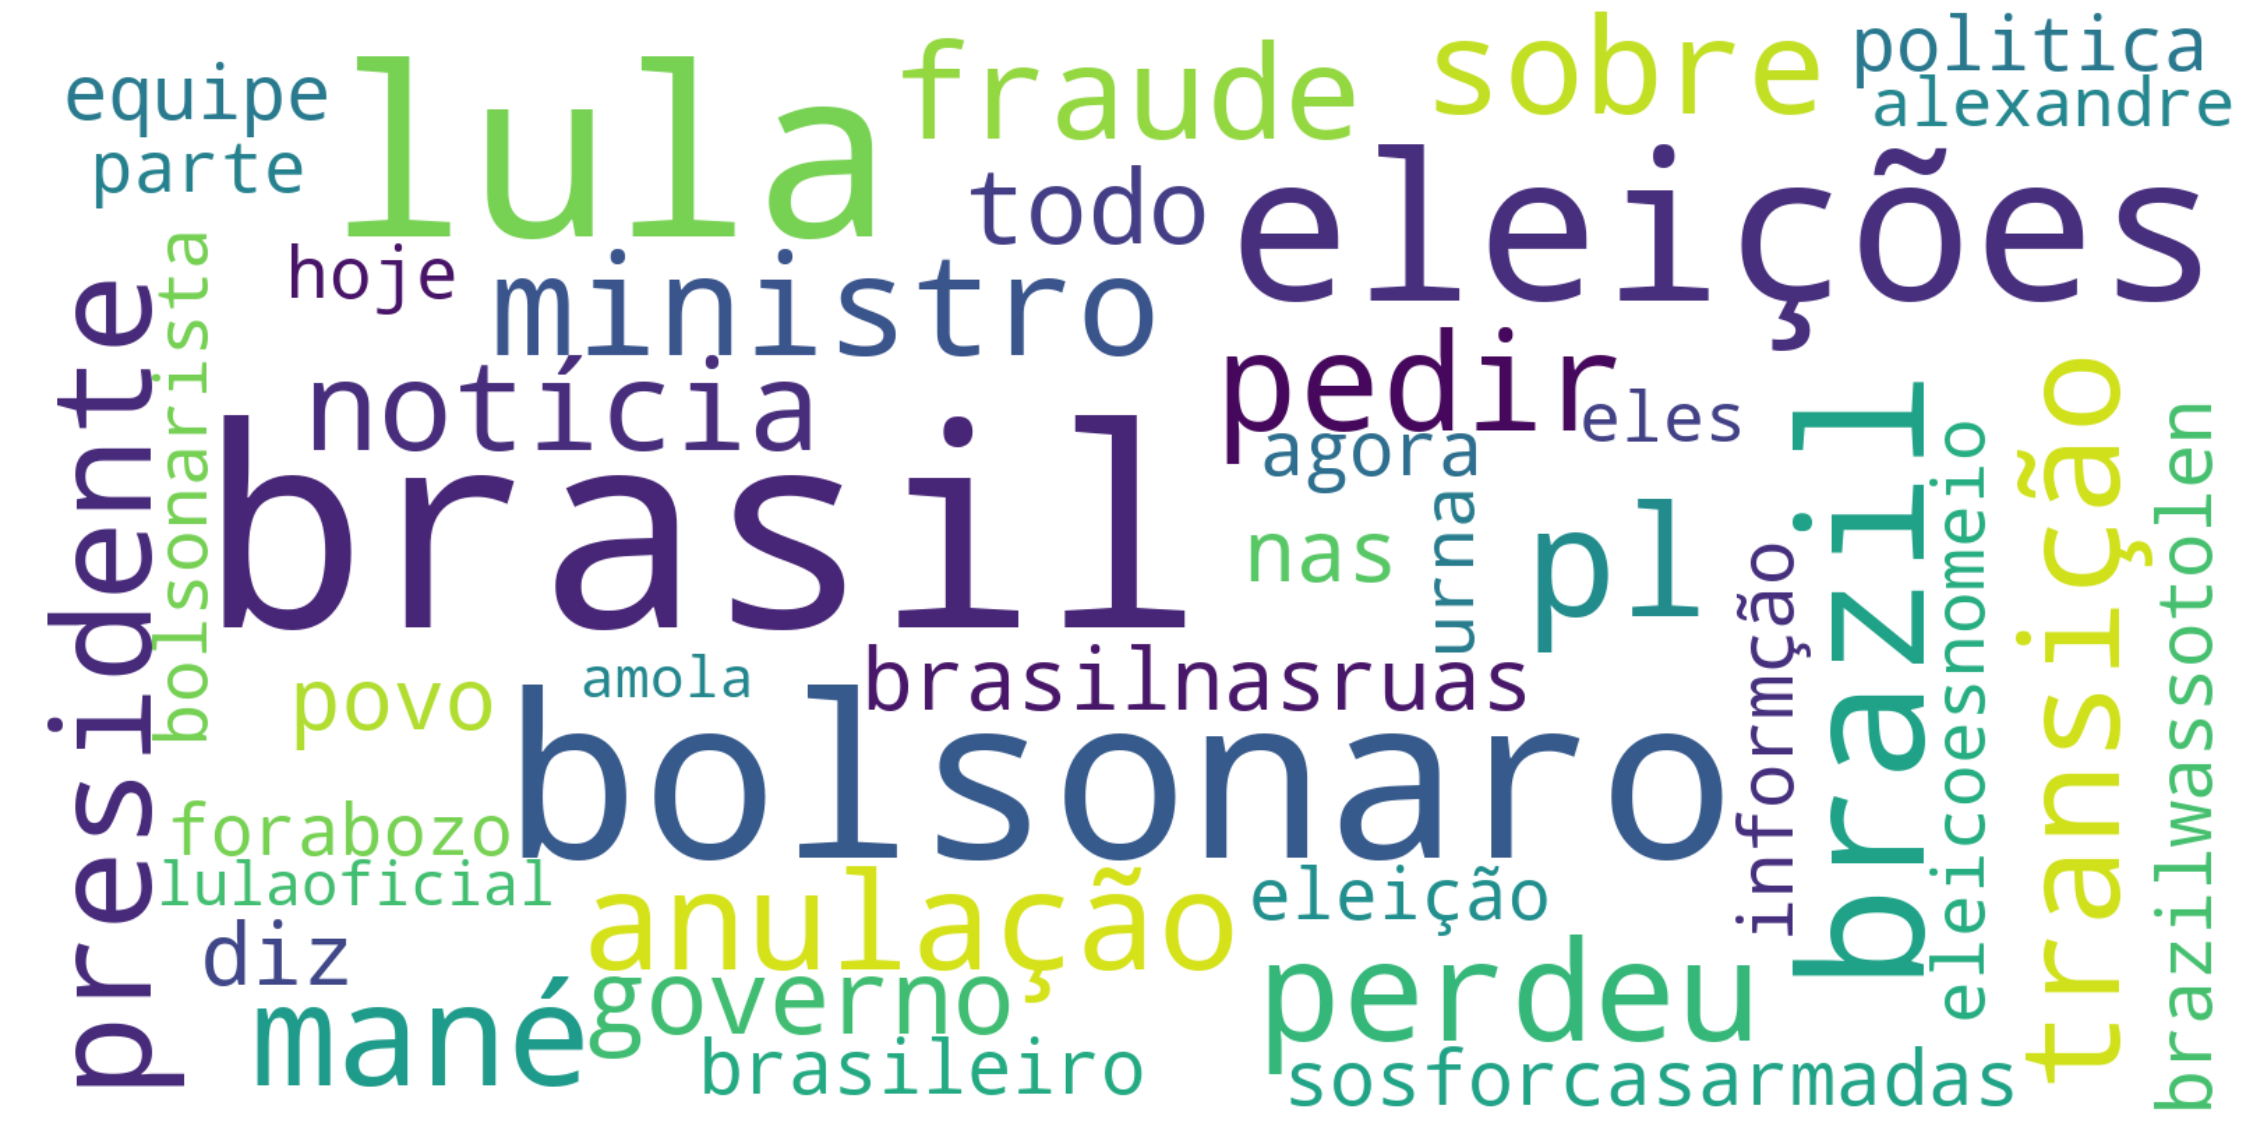

In [116]:
# Word Cloud com os textos dos tweets
wordcloud = WordCloud(width=1600, stopwords=stopwords, height=800,max_font_size=200, max_words=40,collocations=False, background_color='white').generate(string)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()